In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import time
import pickle


# LOADING DATASETS

In [2]:
not_top_100_with_audio_features = pd.read_csv("not_top_100_with_id.csv")
#not_top_100_with_audio_features['hot/not_hot'] = 'H'   # Add column hot/non hot in the new dataframe created above
display(not_top_100_with_audio_features.head())
top_100_with_audio_features = pd.read_csv("top_100_with_audio_features.csv")
#top_100_with_audio_features['hot/not_hot'] = 'N'      # Add column hot/non hot in the new dataframe created above
display(top_100_with_audio_features.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title,hot/not_hot
0,0.838,0.626,0,-4.214,1,0.0396,0.00211,0.000059,0.0221,0.108,...,spotify:track:5YZRZqEkrteLmxvseHnQ2K,https://api.spotify.com/v1/tracks/5YZRZqEkrteL...,https://api.spotify.com/v1/audio-analysis/5YZR...,163514,4,Rap,Live Television,NaN,NaN,N
1,0.611,0.478,0,-5.839,1,0.1070,0.03500,0.000000,0.1070,0.138,...,spotify:track:1AH60dMaEfNjzDoUIFwIQi,https://api.spotify.com/v1/tracks/1AH60dMaEfNj...,https://api.spotify.com/v1/audio-analysis/1AH6...,258158,4,Rap,Beast Mode (feat. PnB Rock & YoungBoy Never Br...,NaN,NaN,N
2,0.744,0.697,11,-5.063,0,0.1970,0.01060,0.000000,0.0842,0.767,...,spotify:track:17husT8tMWaBHcQqUpYDZQ,https://api.spotify.com/v1/tracks/17husT8tMWaB...,https://api.spotify.com/v1/audio-analysis/17hu...,247413,4,Hiphop,Make It Rain,NaN,NaN,N
3,0.823,0.703,8,-2.691,1,0.2980,0.01610,0.000001,0.2940,0.260,...,spotify:track:50I7FNN2rl2rWiNwGxS146,https://api.spotify.com/v1/tracks/50I7FNN2rl2r...,https://api.spotify.com/v1/audio-analysis/50I7...,194214,4,Rap,No Opp Left Behind,NaN,NaN,N
4,0.649,0.200,2,-19.410,1,0.0507,0.83900,0.000306,0.2060,0.866,...,spotify:track:5zDPkwHEID3BErCrgPbBOw,https://api.spotify.com/v1/tracks/5zDPkwHEID3B...,https://api.spotify.com/v1/audio-analysis/5zDP...,160325,4,Dark Trap,Storyboard for a Pessimist,NaN,NaN,N


,Songs,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id.1,uri,track_href,analysis_url,duration_ms,time_signature,hot/not_hot
0,Paint The Town Red,Doja Cat,['56y1jOTK0XSvJzVv9vHQBK'],0.864,0.5560,2,-7.683,0,0.1940,0.2550,...,0.726,99.974,audio_features,56y1jOTK0XSvJzVv9vHQBK,spotify:track:56y1jOTK0XSvJzVv9vHQBK,https://api.spotify.com/v1/tracks/56y1jOTK0XSv...,https://api.spotify.com/v1/audio-analysis/56y1...,230480,4,H
1,Snooze,SZA,['7HNAsAfrpuY7kSbi1Kuk29'],0.212,0.0375,9,-21.159,0,0.0413,0.9920,...,0.120,63.513,audio_features,7HNAsAfrpuY7kSbi1Kuk29,spotify:track:7HNAsAfrpuY7kSbi1Kuk29,https://api.spotify.com/v1/tracks/7HNAsAfrpuY7...,https://api.spotify.com/v1/audio-analysis/7HNA...,90642,4,H
2,Fast Car,Luke Combs,['1ZWEehHLyzfkYn0jVslHCy'],0.918,0.6340,10,-5.176,1,0.3640,0.1710,...,0.932,135.082,audio_features,1ZWEehHLyzfkYn0jVslHCy,spotify:track:1ZWEehHLyzfkYn0jVslHCy,https://api.spotify.com/v1/tracks/1ZWEehHLyzfk...,https://api.spotify.com/v1/audio-analysis/1ZWE...,130889,4,H
3,Cruel Summer,Taylor Swift,['2EGaDf0cPX789H3LNeB03D'],0.666,0.8710,1,-6.017,0,0.0272,0.2700,...,0.936,108.501,audio_features,2EGaDf0cPX789H3LNeB03D,spotify:track:2EGaDf0cPX789H3LNeB03D,https://api.spotify.com/v1/tracks/2EGaDf0cPX78...,https://api.spotify.com/v1/audio-analysis/2EGa...,215326,4,H
4,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,['7pjPeCHhB5gvwONDGvNtH2'],0.603,0.4910,1,-8.745,1,0.0520,0.0212,...,0.355,134.950,audio_features,7pjPeCHhB5gvwONDGvNtH2,spotify:track:7pjPeCHhB5gvwONDGvNtH2,https://api.spotify.com/v1/tracks/7pjPeCHhB5gv...,https://api.spotify.com/v1/audio-analysis/7pjP...,260435,4,H


In [3]:
not_top_100_with_audio_features.columns
not_top_100_with_audio_features.shape

(5132, 23)

In [4]:
top_100_with_audio_features.columns
top_100_with_audio_features.shape

(100, 22)

In [5]:
# Rename "song_name" to "Songs" in the first DataFrame
not_top_100_with_audio_features = not_top_100_with_audio_features.rename(columns={'song_name': 'Songs'})

# Find the common columns between the two DataFrames
common_columns = set(not_top_100_with_audio_features.columns) & set(top_100_with_audio_features.columns)

# Display the common columns
print(common_columns)

{'Songs', 'energy', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'danceability', 'loudness', 'acousticness', 'analysis_url', 'type', 'time_signature', 'mode', 'tempo', 'id', 'key', 'duration_ms', 'hot/not_hot', 'uri', 'track_href'}


# CONCAT THE DATASETS

In [6]:
# Concatenate the two DataFrames vertically
merged_data = pd.concat([not_top_100_with_audio_features, top_100_with_audio_features], ignore_index=True)

# Display the merged data
#print(merged_data)
display(merged_data.head())
merged_data.columns

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,analysis_url,duration_ms,time_signature,genre,Songs,Unnamed: 0,title,hot/not_hot,Artists,id.1
0,0.838,0.626,0,-4.214,1,0.0396,0.00211,0.000059,0.0221,0.108,...,https://api.spotify.com/v1/audio-analysis/5YZR...,163514,4,Rap,Live Television,NaN,NaN,N,NaN,NaN
1,0.611,0.478,0,-5.839,1,0.1070,0.03500,0.000000,0.1070,0.138,...,https://api.spotify.com/v1/audio-analysis/1AH6...,258158,4,Rap,Beast Mode (feat. PnB Rock & YoungBoy Never Br...,NaN,NaN,N,NaN,NaN
2,0.744,0.697,11,-5.063,0,0.1970,0.01060,0.000000,0.0842,0.767,...,https://api.spotify.com/v1/audio-analysis/17hu...,247413,4,Hiphop,Make It Rain,NaN,NaN,N,NaN,NaN
3,0.823,0.703,8,-2.691,1,0.2980,0.01610,0.000001,0.2940,0.260,...,https://api.spotify.com/v1/audio-analysis/50I7...,194214,4,Rap,No Opp Left Behind,NaN,NaN,N,NaN,NaN
4,0.649,0.200,2,-19.410,1,0.0507,0.83900,0.000306,0.2060,0.866,...,https://api.spotify.com/v1/audio-analysis/5zDP...,160325,4,Dark Trap,Storyboard for a Pessimist,NaN,NaN,N,NaN,NaN


Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'Songs', 'Unnamed: 0', 'title',
       'hot/not_hot', 'Artists', 'id.1'],
      dtype='object')

In [7]:
X = merged_data.drop(columns=['id.1', 'title', 'Unnamed: 0'])
X.shape
X.to_csv('merged_data.csv')

# USE DIMENSIONALITY REDUCTION TECHNIQUE TO CREATE 2-3 NEW FEATURES

In [8]:
# shape of dataset
X.shape

(5232, 22)

## scaling features

In [9]:
#check the range of values
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000
mean,0.673213,0.658308,5.142393,-7.034739,0.579511,0.177911,0.169593,0.077910,0.195094,0.420462,151.417797,194352.228593,3.966552
std,0.160951,0.174797,3.670602,3.002797,0.493685,0.142685,0.209194,0.222698,0.148967,0.232761,29.418776,60541.538846,0.317449
min,0.090900,0.016800,0.000000,-33.357000,0.000000,0.023200,0.000002,0.000000,0.022100,0.000010,61.309000,33479.000000,1.000000
25%,0.564000,0.537000,1.000000,-8.663500,0.000000,0.056100,0.017100,0.000000,0.101000,0.226000,129.943000,150075.250000,4.000000
50%,0.696000,0.662000,5.000000,-6.634000,1.000000,0.129000,0.081800,0.000000,0.131000,0.402000,149.127000,192000.000000,4.000000
75%,0.795250,0.790000,8.000000,-5.035500,1.000000,0.278000,0.246250,0.000651,0.250250,0.595250,174.052500,231078.000000,4.000000
max,0.982000,1.000000,11.000000,1.833000,1.000000,0.914000,0.992000,0.989000,0.965000,0.976000,245.859000,632625.000000,5.000000


In [10]:
from sklearn.preprocessing import StandardScaler
X = X.select_dtypes(include=['number'])
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "wine_scaler.pickle" # Path with filename

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.838,0.626,0,-4.214,1,0.0396,0.00211,0.000059,0.0221,0.108,97.994,163514,4
1,0.611,0.478,0,-5.839,1,0.1070,0.03500,0.000000,0.1070,0.138,172.076,258158,4
2,0.744,0.697,11,-5.063,0,0.1970,0.01060,0.000000,0.0842,0.767,149.280,247413,4
3,0.823,0.703,8,-2.691,1,0.2980,0.01610,0.000001,0.2940,0.260,178.043,194214,4
4,0.649,0.200,2,-19.410,1,0.0507,0.83900,0.000306,0.2060,0.866,150.043,160325,4


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.023929,-0.184846,-1.401101,0.939460,0.851818,-0.969440,-0.800687,-0.349613,-1.161401,-1.342545,-1.816150,-0.509422,0.105375
1,-0.386571,-1.031622,-1.401101,0.398246,0.851818,-0.497026,-0.643449,-0.349879,-0.591421,-1.213644,0.702279,1.054018,0.105375
2,0.439845,0.221377,1.595969,0.656697,-1.173960,0.133794,-0.760098,-0.349879,-0.744490,1.488960,-0.072675,0.876520,0.105375
3,0.930724,0.255706,0.778586,1.446703,0.851818,0.841713,-0.733804,-0.349873,0.664013,-0.689451,0.905128,-0.002283,0.105375
4,-0.150452,-2.622186,-0.856179,-4.121639,0.851818,-0.891639,3.200248,-0.348505,0.073220,1.914330,-0.046736,-0.562101,0.105375


In [11]:
X_scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03,5.232000e+03
mean,-9.099076e-17,1.490483e-16,2.037106e-18,1.622895e-16,-4.210020e-17,1.561782e-17,9.506497e-17,-4.889056e-17,-1.901299e-16,1.257913e-16,-6.579854e-16,2.356253e-16,-2.037106e-17
std,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00
min,-3.618291e+00,-3.670357e+00,-1.401101e+00,-8.766753e+00,-1.173960e+00,-1.084389e+00,-8.107637e-01,-3.498794e-01,-1.161401e+00,-1.806542e+00,-3.063262e+00,-2.657491e+00,-9.345878e+00
25%,-6.786122e-01,-6.940559e-01,-1.128640e+00,-5.424666e-01,-1.173960e+00,-8.537896e-01,-7.290237e-01,-3.498794e-01,-6.317021e-01,-8.355376e-01,-7.300389e-01,-7.314186e-01,1.053752e-01
50%,1.415899e-01,2.112597e-02,-3.879652e-02,1.334680e-01,8.518179e-01,-3.428257e-01,-4.197113e-01,-3.498794e-01,-4.302956e-01,-7.932389e-02,-7.787599e-02,-3.885685e-02,1.053752e-01
75%,7.582949e-01,7.534722e-01,7.785863e-01,6.658560e-01,8.518179e-01,7.015312e-01,3.664776e-01,-3.469548e-01,3.702949e-01,7.510074e-01,7.694700e-01,6.066790e-01,1.053752e-01
max,1.918695e+00,1.954978e+00,1.595969e+00,2.953442e+00,8.518179e-01,5.159323e+00,3.931698e+00,4.091528e+00,5.168803e+00,2.386964e+00,3.210542e+00,7.239900e+00,3.255793e+00


## PCA

In [12]:
from sklearn.decomposition import PCA

# When we create an instance of PCA, we can specify how many principal components we want to extract.
# However, as we don't know beforehand how much variance it will explain each principal component it's
# allways better to not set the option "n_components" to a given integer number.

pca = PCA()
pca.fit(X_scaled_df)
principal_components = pca.transform(X_scaled_df)
principal_components_df = pd.DataFrame(principal_components, columns=['PCA_'+ str(i) for i in range(1,X_scaled_df.shape[1]+1)])
principal_components_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,0.067670,0.080382,-2.794099,-1.535904,-0.204063,1.173428,0.001738,-0.495036,-0.595984,0.518781,-0.344626,-0.665244,-0.225787
1,0.519203,0.625307,-1.460101,0.691633,-1.646123,-0.314800,-0.085862,-0.159767,-0.722224,0.583914,-0.877234,-0.226405,-0.697488
2,-1.043939,-0.433812,1.960269,-1.377190,-0.732517,0.544290,-0.320690,0.637473,-0.115377,0.259554,0.079882,0.488118,-0.433992
3,-1.566514,-0.257298,-0.085684,0.363824,0.240689,-0.466699,-0.512610,0.645240,0.237050,0.962375,-0.870511,-1.395606,-0.412031
4,4.138296,-2.695126,-0.052064,1.259087,-0.336033,-0.387464,1.643135,-0.391890,1.669092,-2.116406,0.086817,1.911404,0.694694


In [13]:
print(pca.explained_variance_ratio_)   # percentage of variance explained by each principal component.

[0.17038592 0.13312937 0.09909155 0.08832929 0.0788455  0.07288139
 0.07054437 0.06173216 0.05992846 0.05563235 0.05376457 0.03798837
 0.01774671]


cummulative variance ratio to understand how many components to be taken to obtain best features

In [14]:
cumulated_explained_variance_ratio = [sum(pca.explained_variance_ratio_[0:i+1]) for i,value in enumerate(pca.explained_variance_ratio_)]
cumulated_explained_variance_ratio

[0.17038591946766823,
 0.303515289029832,
 0.4026068359559561,
 0.4909361225183662,
 0.5697816239454779,
 0.6426630168894947,
 0.7132073859337998,
 0.7749395420342402,
 0.8348680026410995,
 0.8905003557955714,
 0.9442649225105952,
 0.9822532878543215,
 1.0]

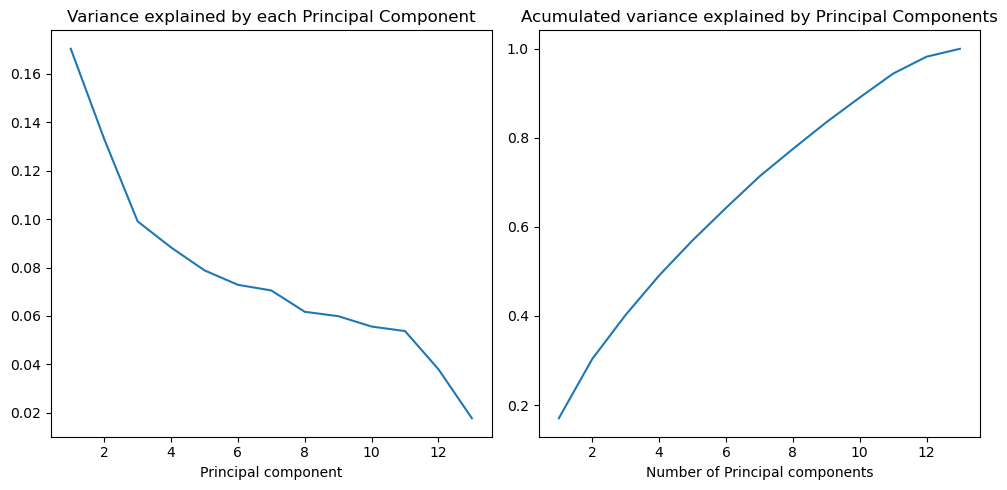

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(np.arange(1,14), pca.explained_variance_ratio_)
ax[0].set_xlabel("Principal component")
ax[0].set_title("Variance explained by each Principal Component")
ax[1].plot(np.arange(1,14),cumulated_explained_variance_ratio)
ax[1].set_title("Acumulated variance explained by Principal Components")
ax[1].set_xlabel("Number of Principal components")
plt.tight_layout()
plt.show()

## isomap

In [16]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=12, n_components=2)
iso.fit(X)
X_isomap_transformed = iso.transform(X)
X_isomap_transformed_df = pd.DataFrame(X_isomap_transformed, columns=["ISO_1","ISO_2"])
X_isomap_transformed_df.head()

,ISO_1,ISO_2
0,-30915.581563,385.987720
1,63958.748380,-112.049164
2,53196.728295,-33.416271
3,-123.328468,174.227027
4,-34107.604709,-43.324038


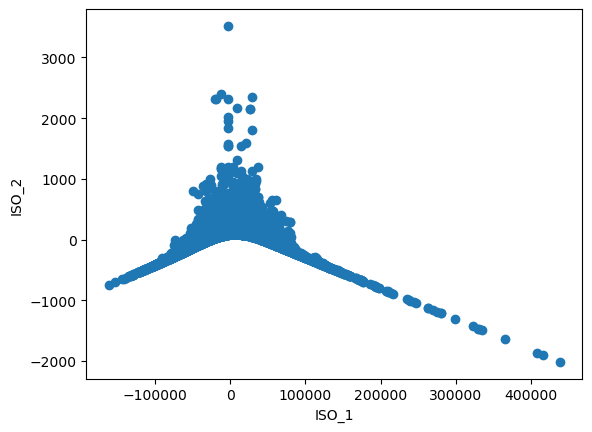

In [17]:
fig, ax = plt.subplots()
ax.scatter(X_isomap_transformed_df['ISO_1'],X_isomap_transformed_df['ISO_2'])
ax.set_xlabel("ISO_1")
ax.set_ylabel("ISO_2")
plt.show()

## tsne

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=100, init='random', perplexity=40, random_state=12)

X_tsne_transformed = tsne.fit_transform(X)
X_tsne_transformed_df = pd.DataFrame(X_tsne_transformed, columns=["TSNE_1","TSNE_2"])
X_tsne_transformed_df.head()

,TSNE_1,TSNE_2
0,-50.464500,-1.226249
1,-16.006847,57.988865
2,13.683574,51.134544
3,39.110176,0.456049
4,-60.340992,-8.985458


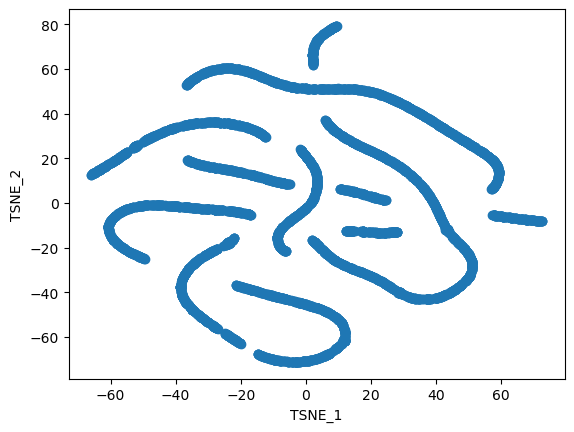

In [19]:
fig, ax = plt.subplots()
ax.scatter(X_tsne_transformed_df['TSNE_1'],X_tsne_transformed_df['TSNE_2'])
ax.set_xlabel("TSNE_1")
ax.set_ylabel("TSNE_2")
plt.show()

get a dataset using the features best predicted by any one of the techniques

using tsne method 

save the data set

In [20]:
less_features_df = X_tsne_transformed_df
less_features_df.to_csv(r"./less_features_df.csv", index=False)

# Clustering  with K-Means

In [21]:
import pandas as pd
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:
kmeans = KMeans(n_clusters=8, random_state=1234 , n_init=10)
kmeans.fit(X_scaled_df)

KMeans(n_init=10, random_state=1234)

In [23]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0     843
1     397
2     974
3    1041
4     419
5     183
6     917
7     458
dtype: int64

In [24]:
X["cluster"] = clusters
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0.838,0.626,0,-4.214,1,0.0396,0.00211,0.000059,0.0221,0.108,97.994,163514,4,3
1,0.611,0.478,0,-5.839,1,0.1070,0.03500,0.000000,0.1070,0.138,172.076,258158,4,0
2,0.744,0.697,11,-5.063,0,0.1970,0.01060,0.000000,0.0842,0.767,149.280,247413,4,2
3,0.823,0.703,8,-2.691,1,0.2980,0.01610,0.000001,0.2940,0.260,178.043,194214,4,2
4,0.649,0.200,2,-19.410,1,0.0507,0.83900,0.000306,0.2060,0.866,150.043,160325,4,4


# Chosing K


Initialization complete
Iteration 0, inertia 88308.41643858056.
Iteration 1, inertia 62650.43305405552.
Iteration 2, inertia 61960.64332869527.
Iteration 3, inertia 61520.72261973675.
Iteration 4, inertia 61297.84842401941.
Iteration 5, inertia 61165.74318008264.
Iteration 6, inertia 61067.99515204326.
Iteration 7, inertia 61006.847119210375.
Iteration 8, inertia 60977.343435781506.
Iteration 9, inertia 60958.80846092486.
Iteration 10, inertia 60943.009591786555.
Iteration 11, inertia 60930.02669519563.
Iteration 12, inertia 60921.892223137016.
Iteration 13, inertia 60916.65124896187.
Iteration 14, inertia 60913.15845991414.
Iteration 15, inertia 60911.16639112082.
Iteration 16, inertia 60910.3109915932.
Converged at iteration 16: center shift 8.368098451667269e-05 within tolerance 0.00010000000000000087.
Initialization complete


C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 96132.39856522663.
Iteration 1, inertia 63850.02360530555.
Iteration 2, inertia 62588.1382747063.
Iteration 3, inertia 61666.22489316935.
Iteration 4, inertia 61225.16147269158.
Iteration 5, inertia 61074.86152423901.
Iteration 6, inertia 61006.810943001605.
Iteration 7, inertia 60971.81928156417.
Iteration 8, inertia 60947.17412132533.
Iteration 9, inertia 60931.12026058268.
Iteration 10, inertia 60921.43944278227.
Iteration 11, inertia 60915.72699576129.
Iteration 12, inertia 60913.64119024131.
Iteration 13, inertia 60912.99026643274.
Iteration 14, inertia 60912.10441968704.
Iteration 15, inertia 60911.03799672921.
Iteration 16, inertia 60910.408989292264.
Iteration 17, inertia 60909.88678099144.
Converged at iteration 17: center shift 7.994031769341164e-05 within tolerance 0.00010000000000000087.
Initialization complete
Iteration 0, inertia 90691.25352014252.
Iteration 1, inertia 64228.961257437666.
Iteration 2, inertia 63160.32655418423.
Iteration 3, inertia 62


Initialization complete
Iteration 0, inertia 79589.13559369698.
Iteration 1, inertia 57879.210929445115.
Iteration 2, inertia 57227.22175686275.
Iteration 3, inertia 56971.226558462644.
Iteration 4, inertia 56849.78505274969.
Iteration 5, inertia 56778.288903491775.
Iteration 6, inertia 56743.51088408516.
Iteration 7, inertia 56722.57561918101.
Iteration 8, inertia 56707.94780609525.
Iteration 9, inertia 56698.115013056864.
Iteration 10, inertia 56691.390789125864.
Iteration 11, inertia 56685.22158004855.
Iteration 12, inertia 56681.40707388225.
Iteration 13, inertia 56676.77899254625.
Iteration 14, inertia 56672.54287213064.
Iteration 15, inertia 56668.595887184936.
Iteration 16, inertia 56666.05281501188.
Iteration 17, inertia 56663.41238133594.
Iteration 18, inertia 56661.536164962825.
Iteration 19, inertia 56660.161363408944.
Iteration 20, inertia 56659.750132895104.
Iteration 21, inertia 56659.28719949174.
Iteration 22, inertia 56658.02646283615.
Iteration 23, inertia 56656.69083

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 77813.90864835423.
Iteration 1, inertia 58584.922915253344.
Iteration 2, inertia 56999.50538441833.
Iteration 3, inertia 56507.72390444159.
Iteration 4, inertia 56236.91389100365.
Iteration 5, inertia 56055.24961950451.
Iteration 6, inertia 56003.61559909183.
Iteration 7, inertia 55981.64545824423.
Iteration 8, inertia 55969.92654523089.
Iteration 9, inertia 55963.955843593416.
Iteration 10, inertia 55961.11291444821.
Iteration 11, inertia 55959.72326833933.
Iteration 12, inertia 55959.10120726479.
Iteration 13, inertia 55958.63049507479.
Iteration 14, inertia 55958.09734634112.
Converged at iteration 14: center shift 3.504721584269697e-05 within tolerance 0.00010000000000000087.
Initialization complete
Iteration 0, inertia 87017.15849703866.
Iteration 1, inertia 58497.990784971465.
Iteration 2, inertia 57952.351328300494.
Iteration 3, inertia 57742.183745099275.
Iteration 4, inertia 57657.203275249514.
Iteration 5, inertia 57604.74914161745.
Iteration 6, inertia 5

Iteration 0, inertia 86310.99254404739.
Iteration 1, inertia 58427.94873377374.
Iteration 2, inertia 57473.67708574632.
Iteration 3, inertia 56893.45128440696.
Iteration 4, inertia 56392.21307667879.
Iteration 5, inertia 56066.230565406666.
Iteration 6, inertia 55992.81282866901.
Iteration 7, inertia 55979.37121770264.
Iteration 8, inertia 55972.82983818104.
Iteration 9, inertia 55966.61012691302.
Iteration 10, inertia 55962.63354008193.
Iteration 11, inertia 55960.1910967853.
Iteration 12, inertia 55958.89739396071.
Iteration 13, inertia 55958.05858587786.
Iteration 14, inertia 55957.58605650439.
Converged at iteration 14: center shift 5.978976163832847e-05 within tolerance 0.00010000000000000087.
Initialization complete
Iteration 0, inertia 74219.51481022984.
Iteration 1, inertia 60403.88184583154.
Iteration 2, inertia 58363.18826854204.
Iteration 3, inertia 57479.976513626374.
Iteration 4, inertia 57218.02270231361.
Iteration 5, inertia 57113.035270794426.
Iteration 6, inertia 57074

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 85342.8206442061.
Iteration 1, inertia 56022.092577200376.
Iteration 2, inertia 54879.404868083024.
Iteration 3, inertia 54316.4337578037.
Iteration 4, inertia 54102.827208276976.
Iteration 5, inertia 54003.86973216841.
Iteration 6, inertia 53930.83045692011.
Iteration 7, inertia 53873.88913947963.
Iteration 8, inertia 53820.578378082595.
Iteration 9, inertia 53755.51962653411.
Iteration 10, inertia 53653.34152856711.
Iteration 11, inertia 53510.36238507119.
Iteration 12, inertia 53258.152900392815.
Iteration 13, inertia 53035.15263852292.
Iteration 14, inertia 52938.76121655276.
Iteration 15, inertia 52889.35113213496.
Iteration 16, inertia 52856.02053388146.
Iteration 17, inertia 52832.35216534947.
Iteration 18, inertia 52811.9347768602.
Iteration 19, inertia 52795.72979108529.
Iteration 20, inertia 52780.580847239806.
Iteration 21, inertia 52769.24727176251.
Iteration 22, inertia 52762.03259826383.
Iteration 23, inertia 52757.174539879954.
Iteration 24, inertia 

Iteration 7, inertia 54039.53490372861.
Iteration 8, inertia 53988.97920146055.
Iteration 9, inertia 53949.31525022619.
Iteration 10, inertia 53921.82498134881.
Iteration 11, inertia 53904.25505809559.
Iteration 12, inertia 53889.91657254996.
Iteration 13, inertia 53872.695493774336.
Iteration 14, inertia 53847.440396758306.
Iteration 15, inertia 53808.41924110863.
Iteration 16, inertia 53748.958141333955.
Iteration 17, inertia 53655.854251109435.
Iteration 18, inertia 53495.4229500539.
Iteration 19, inertia 53250.45272478181.
Iteration 20, inertia 52962.50508269261.
Iteration 21, inertia 52832.41606756754.
Iteration 22, inertia 52808.15616896729.
Iteration 23, inertia 52801.133304067596.
Iteration 24, inertia 52793.62080503257.
Iteration 25, inertia 52788.17719395785.
Iteration 26, inertia 52784.382789849675.
Iteration 27, inertia 52780.86023763872.
Iteration 28, inertia 52779.03041964408.
Iteration 29, inertia 52778.04263522388.
Iteration 30, inertia 52776.64623525931.
Iteration 31, 

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 3, inertia 50709.75084547777.
Iteration 4, inertia 50517.64707475941.
Iteration 5, inertia 50350.07007890419.
Iteration 6, inertia 50184.498136293405.
Iteration 7, inertia 50067.13468599564.
Iteration 8, inertia 49985.05866749346.
Iteration 9, inertia 49927.52736277463.
Iteration 10, inertia 49880.74617523982.
Iteration 11, inertia 49844.06604197318.
Iteration 12, inertia 49819.5112696012.
Iteration 13, inertia 49800.189084679034.
Iteration 14, inertia 49784.86522534021.
Iteration 15, inertia 49767.61883059724.
Iteration 16, inertia 49745.12897259694.
Iteration 17, inertia 49720.58693080026.
Iteration 18, inertia 49699.5409887831.
Iteration 19, inertia 49686.18338584884.
Iteration 20, inertia 49676.479651427864.
Iteration 21, inertia 49670.66692477997.
Iteration 22, inertia 49669.37168231252.
Iteration 23, inertia 49668.935264040796.
Iteration 24, inertia 49668.68164189284.
Iteration 25, inertia 49668.37981416036.
Iteration 26, inertia 49668.17391507229.
Converged at iteratio

Iteration 0, inertia 68588.48833182201.
Iteration 1, inertia 55082.805287828334.
Iteration 2, inertia 53747.85990003387.
Iteration 3, inertia 53384.84039402253.
Iteration 4, inertia 53208.990898874654.
Iteration 5, inertia 53075.403172406215.
Iteration 6, inertia 52996.823276911346.
Iteration 7, inertia 52945.7226082199.
Iteration 8, inertia 52906.045291423135.
Iteration 9, inertia 52875.72121046744.
Iteration 10, inertia 52855.40458259531.
Iteration 11, inertia 52846.52071177593.
Iteration 12, inertia 52839.385227005565.
Iteration 13, inertia 52830.792287882476.
Iteration 14, inertia 52822.66654950558.
Iteration 15, inertia 52818.261376052345.
Iteration 16, inertia 52815.07116728378.
Iteration 17, inertia 52812.44221445761.
Iteration 18, inertia 52809.923751719914.
Iteration 19, inertia 52808.584431134914.
Iteration 20, inertia 52807.2681348693.
Iteration 21, inertia 52806.30819732126.
Iteration 22, inertia 52805.97682743202.
Iteration 23, inertia 52805.785500117774.
Converged at iter

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 35, inertia 47558.24596696795.
Iteration 36, inertia 47556.152446918866.
Iteration 37, inertia 47554.77602974741.
Iteration 38, inertia 47553.55514334344.
Iteration 39, inertia 47552.708979007104.
Iteration 40, inertia 47551.99280946594.
Iteration 41, inertia 47551.310427901015.
Iteration 42, inertia 47551.10009574125.
Iteration 43, inertia 47550.88103768376.
Converged at iteration 43: center shift 9.465996430183554e-05 within tolerance 0.00010000000000000087.
Initialization complete
Iteration 0, inertia 64928.57677766747.
Iteration 1, inertia 50559.98350718587.
Iteration 2, inertia 49351.54942321128.
Iteration 3, inertia 48897.42621089121.
Iteration 4, inertia 48588.842171349475.
Iteration 5, inertia 48221.06926096133.
Iteration 6, inertia 47860.2019046033.
Iteration 7, inertia 47656.43187131481.
Iteration 8, inertia 47542.44404864239.
Iteration 9, inertia 47481.571402033194.
Iteration 10, inertia 47435.14193326209.
Iteration 11, inertia 47388.269294904654.
Iteration 12, ine

Iteration 34, inertia 47820.98252525345.
Iteration 35, inertia 47813.63082736938.
Iteration 36, inertia 47804.293148021185.
Iteration 37, inertia 47791.468813674204.
Iteration 38, inertia 47782.48253947027.
Iteration 39, inertia 47773.48670012429.
Iteration 40, inertia 47762.62910606448.
Iteration 41, inertia 47747.199882662004.
Iteration 42, inertia 47725.75822689859.
Iteration 43, inertia 47706.161433541354.
Iteration 44, inertia 47688.729382077974.
Iteration 45, inertia 47678.357346193436.
Iteration 46, inertia 47672.242722416006.
Iteration 47, inertia 47667.38574464581.
Iteration 48, inertia 47663.07311738421.
Iteration 49, inertia 47658.84246570743.
Iteration 50, inertia 47653.823018133065.
Iteration 51, inertia 47650.020992843536.
Iteration 52, inertia 47647.56303886647.
Iteration 53, inertia 47644.82517602443.
Iteration 54, inertia 47642.25772519165.
Iteration 55, inertia 47638.825356877365.
Iteration 56, inertia 47634.68585325412.
Iteration 57, inertia 47629.90262544125.
Iterat


Initialization complete
Iteration 0, inertia 64475.366672933575.
Iteration 1, inertia 49948.32217226029.
Iteration 2, inertia 48382.89604424705.
Iteration 3, inertia 47712.727352499875.
Iteration 4, inertia 47188.27217690271.
Iteration 5, inertia 46784.17032105174.
Iteration 6, inertia 46472.78485334729.
Iteration 7, inertia 46279.845844296055.
Iteration 8, inertia 46166.379462037585.
Iteration 9, inertia 46105.57799943141.
Iteration 10, inertia 46058.70516971777.
Iteration 11, inertia 46017.41925923868.
Iteration 12, inertia 45975.32753506753.
Iteration 13, inertia 45939.85796676372.
Iteration 14, inertia 45898.063995735254.
Iteration 15, inertia 45863.584573631815.
Iteration 16, inertia 45839.808660719376.
Iteration 17, inertia 45820.27051192735.
Iteration 18, inertia 45811.34900937822.
Iteration 19, inertia 45807.68708599929.
Iteration 20, inertia 45806.3507314033.
Iteration 21, inertia 45805.11586235373.
Iteration 22, inertia 45804.52996739348.
Iteration 23, inertia 45804.30629946

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 60900.97488974494.
Iteration 1, inertia 48625.29431651535.
Iteration 2, inertia 47644.02632134386.
Iteration 3, inertia 46999.34204547918.
Iteration 4, inertia 46678.395250098394.
Iteration 5, inertia 46433.07039130779.
Iteration 6, inertia 46301.66699384397.
Iteration 7, inertia 46232.998975689254.
Iteration 8, inertia 46181.994674582995.
Iteration 9, inertia 46123.648955239274.
Iteration 10, inertia 46049.39081690082.
Iteration 11, inertia 45950.52333712335.
Iteration 12, inertia 45849.79780087282.
Iteration 13, inertia 45750.873491400715.
Iteration 14, inertia 45690.03776403262.
Iteration 15, inertia 45662.04638257462.
Iteration 16, inertia 45642.51601886583.
Iteration 17, inertia 45632.49497332419.
Iteration 18, inertia 45628.39466406981.
Iteration 19, inertia 45626.52614670147.
Iteration 20, inertia 45625.55397239135.
Iteration 21, inertia 45625.04383438004.
Iteration 22, inertia 45624.42810416508.
Iteration 23, inertia 45623.7138907497

Iteration 10, inertia 46412.671955270656.
Iteration 11, inertia 46378.68695233976.
Iteration 12, inertia 46348.07467252115.
Iteration 13, inertia 46318.18957614798.
Iteration 14, inertia 46288.95759218338.
Iteration 15, inertia 46265.90452409601.
Iteration 16, inertia 46252.76913183346.
Iteration 17, inertia 46245.452438605076.
Iteration 18, inertia 46240.92256999236.
Iteration 19, inertia 46236.65810055291.
Iteration 20, inertia 46229.88944449906.
Iteration 21, inertia 46224.039861728736.
Iteration 22, inertia 46219.930900729036.
Iteration 23, inertia 46215.255733692786.
Iteration 24, inertia 46210.497750932926.
Iteration 25, inertia 46205.51076313509.
Iteration 26, inertia 46199.26604982569.
Iteration 27, inertia 46189.47806190941.
Iteration 28, inertia 46180.71296798443.
Iteration 29, inertia 46169.81324619243.
Iteration 30, inertia 46157.68935091416.
Iteration 31, inertia 46141.421450914706.
Iteration 32, inertia 46126.968735921684.
Iteration 33, inertia 46113.369607319655.
Iterati

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 63754.775179630546.
Iteration 1, inertia 51102.52884769819.
Iteration 2, inertia 49179.62111782995.
Iteration 3, inertia 48148.23974059293.
Iteration 4, inertia 47424.05061520201.
Iteration 5, inertia 46808.49214875602.
Iteration 6, inertia 46113.09902754277.
Iteration 7, inertia 45379.72017425109.
Iteration 8, inertia 44958.51045818936.
Iteration 9, inertia 44680.48350884521.
Iteration 10, inertia 44336.18745336905.
Iteration 11, inertia 43964.38520824275.
Iteration 12, inertia 43814.49849739875.
Iteration 13, inertia 43760.91169177073.
Iteration 14, inertia 43721.546019058296.
Iteration 15, inertia 43699.55675063549.
Iteration 16, inertia 43687.26114316919.
Iteration 17, inertia 43683.84067175189.
Iteration 18, inertia 43679.85823062348.
Iteration 19, inertia 43676.18724628455.
Iteration 20, inertia 43672.068110704255.
Iteration 21, inertia 43666.61757546138.
Iteration 22, inertia 43661.07218664233.
Iteration 23, inertia 43655.56399482244.
Iteration 24, inertia 4

Iteration 29, inertia 43674.34070506683.
Iteration 30, inertia 43669.211845591286.
Iteration 31, inertia 43661.17796688814.
Iteration 32, inertia 43652.44976556277.
Iteration 33, inertia 43645.287944099626.
Iteration 34, inertia 43638.54510263292.
Iteration 35, inertia 43634.65281948395.
Iteration 36, inertia 43632.008420508624.
Iteration 37, inertia 43629.54426387514.
Iteration 38, inertia 43627.458730993625.
Iteration 39, inertia 43625.30721099499.
Iteration 40, inertia 43622.63491854731.
Iteration 41, inertia 43620.373680619414.
Iteration 42, inertia 43619.141042066876.
Iteration 43, inertia 43617.036134621456.
Iteration 44, inertia 43615.11651261933.
Iteration 45, inertia 43614.08253972239.
Iteration 46, inertia 43613.531240880446.
Iteration 47, inertia 43612.82537603463.
Iteration 48, inertia 43611.92094754055.
Iteration 49, inertia 43611.267152889086.
Iteration 50, inertia 43610.74350858046.
Iteration 51, inertia 43610.48606349176.
Iteration 52, inertia 43610.17145968816.
Iterati

Iteration 0, inertia 60007.98173376848.
Iteration 1, inertia 48259.416788411785.
Iteration 2, inertia 47026.109422039815.
Iteration 3, inertia 46408.12779807397.
Iteration 4, inertia 45960.415611075514.
Iteration 5, inertia 45705.35542459394.
Iteration 6, inertia 45549.082063200505.
Iteration 7, inertia 45482.685642514174.
Iteration 8, inertia 45434.342705577.
Iteration 9, inertia 45402.46681628146.
Iteration 10, inertia 45384.72529683329.
Iteration 11, inertia 45369.28046884798.
Iteration 12, inertia 45360.44910361708.
Iteration 13, inertia 45353.42452126171.
Iteration 14, inertia 45348.85119969052.
Iteration 15, inertia 45344.47411577421.
Iteration 16, inertia 45342.534013770775.
Iteration 17, inertia 45341.47005620316.
Iteration 18, inertia 45340.47541860843.
Iteration 19, inertia 45339.544940963075.
Iteration 20, inertia 45338.602034181946.
Iteration 21, inertia 45338.043912976624.
Iteration 22, inertia 45337.656089123324.
Iteration 23, inertia 45337.22103159251.
Iteration 24, iner

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 11, inertia 42530.83813226819.
Iteration 12, inertia 42494.69542528113.
Iteration 13, inertia 42476.121599931656.
Iteration 14, inertia 42462.53939595324.
Iteration 15, inertia 42453.40920000117.
Iteration 16, inertia 42447.37523277593.
Iteration 17, inertia 42444.12651391212.
Iteration 18, inertia 42439.40914101979.
Iteration 19, inertia 42436.55663112859.
Iteration 20, inertia 42433.047198627246.
Iteration 21, inertia 42430.67869777111.
Iteration 22, inertia 42429.33717109311.
Iteration 23, inertia 42427.626065476186.
Iteration 24, inertia 42424.01106087326.
Iteration 25, inertia 42415.5436539975.
Iteration 26, inertia 42402.49735826009.
Iteration 27, inertia 42383.015487521116.
Iteration 28, inertia 42363.02482625016.
Iteration 29, inertia 42345.92887005168.
Iteration 30, inertia 42333.24115673199.
Iteration 31, inertia 42320.778478699096.
Iteration 32, inertia 42310.362258125046.
Iteration 33, inertia 42298.52530141211.
Iteration 34, inertia 42288.413984887375.
Iteration 

Iteration 0, inertia 55790.48579035996.
Iteration 1, inertia 45035.80378942049.
Iteration 2, inertia 43865.98450564277.
Iteration 3, inertia 43238.01097914335.
Iteration 4, inertia 42915.639868301274.
Iteration 5, inertia 42763.83740286828.
Iteration 6, inertia 42664.27493622344.
Iteration 7, inertia 42598.66312361885.
Iteration 8, inertia 42548.71170661737.
Iteration 9, inertia 42513.988172634.
Iteration 10, inertia 42486.131586951.
Iteration 11, inertia 42449.84243040225.
Iteration 12, inertia 42420.457063079484.
Iteration 13, inertia 42397.35104054681.
Iteration 14, inertia 42379.51046317689.
Iteration 15, inertia 42361.86628801184.
Iteration 16, inertia 42350.1108265963.
Iteration 17, inertia 42339.440413102086.
Iteration 18, inertia 42323.990435259584.
Iteration 19, inertia 42308.97400267439.
Iteration 20, inertia 42298.37584895306.
Iteration 21, inertia 42292.005774883044.
Iteration 22, inertia 42286.35124681509.
Iteration 23, inertia 42281.757592107315.
Iteration 24, inertia 422


Initialization complete
Iteration 0, inertia 56384.40069147724.
Iteration 1, inertia 45602.44159847033.
Iteration 2, inertia 44202.42612932219.
Iteration 3, inertia 43463.352625069376.
Iteration 4, inertia 42963.20752463168.
Iteration 5, inertia 42653.0172660445.
Iteration 6, inertia 42455.00872440613.
Iteration 7, inertia 42276.54204921742.
Iteration 8, inertia 42149.38426356945.
Iteration 9, inertia 42056.18620877596.
Iteration 10, inertia 41998.477633503506.
Iteration 11, inertia 41942.05798374994.
Iteration 12, inertia 41828.25992658414.
Iteration 13, inertia 41690.486568380824.
Iteration 14, inertia 41564.79676332204.
Iteration 15, inertia 41465.79422540459.
Iteration 16, inertia 41388.40556096862.
Iteration 17, inertia 41344.7926579608.
Iteration 18, inertia 41324.55683531861.
Iteration 19, inertia 41310.61607017457.
Iteration 20, inertia 41304.33092633771.
Iteration 21, inertia 41299.31065491547.
Iteration 22, inertia 41295.10641168914.
Iteration 23, inertia 41291.23745000665.


C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 58589.36065694363.
Iteration 1, inertia 46083.25115376131.
Iteration 2, inertia 44728.55367274479.
Iteration 3, inertia 44190.076442922546.
Iteration 4, inertia 43830.70917701816.
Iteration 5, inertia 43570.46900156468.
Iteration 6, inertia 43395.823734232865.
Iteration 7, inertia 43214.16830368455.
Iteration 8, inertia 43067.0276453886.
Iteration 9, inertia 42952.92780205587.
Iteration 10, inertia 42882.63331601602.
Iteration 11, inertia 42822.4419601132.
Iteration 12, inertia 42766.14224470175.
Iteration 13, inertia 42716.74617142.
Iteration 14, inertia 42662.63579416181.
Iteration 15, inertia 42602.48667229009.
Iteration 16, inertia 42543.782416554444.
Iteration 17, inertia 42500.983095584226.
Iteration 18, inertia 42473.27469580234.
Iteration 19, inertia 42456.084738002864.
Iteration 20, inertia 42446.99909385678.
Iteration 21, inertia 42441.62809695525.
Iteration 22, inertia 42437.58873887361.
Iteration 23, inertia 42434.915917886596.
I

Iteration 6, inertia 43446.65001895369.
Iteration 7, inertia 43381.10137046213.
Iteration 8, inertia 43326.22663748029.
Iteration 9, inertia 43283.314495864244.
Iteration 10, inertia 43237.620161122366.
Iteration 11, inertia 43202.60192464819.
Iteration 12, inertia 43163.08300623272.
Iteration 13, inertia 43114.30947407904.
Iteration 14, inertia 43052.06127514988.
Iteration 15, inertia 42991.74965880383.
Iteration 16, inertia 42926.71646675701.
Iteration 17, inertia 42872.971848192785.
Iteration 18, inertia 42830.50437722707.
Iteration 19, inertia 42791.208714239794.
Iteration 20, inertia 42741.85364646203.
Iteration 21, inertia 42691.87033149961.
Iteration 22, inertia 42654.98612341576.
Iteration 23, inertia 42625.55903560129.
Iteration 24, inertia 42603.34923212065.
Iteration 25, inertia 42586.89706225652.
Iteration 26, inertia 42577.95257792891.
Iteration 27, inertia 42571.783859308875.
Iteration 28, inertia 42567.77757514305.
Iteration 29, inertia 42564.933820250444.
Iteration 30, 

Iteration 0, inertia 52773.61705658466.
Iteration 1, inertia 45215.845248322556.
Iteration 2, inertia 43931.60804422811.
Iteration 3, inertia 43166.47260565572.
Iteration 4, inertia 42839.535967722084.
Iteration 5, inertia 42632.529386615286.
Iteration 6, inertia 42389.65507077479.
Iteration 7, inertia 42079.204897043484.
Iteration 8, inertia 41711.74979578667.
Iteration 9, inertia 41331.89379319278.
Iteration 10, inertia 41146.0277511313.
Iteration 11, inertia 41064.49508221724.
Iteration 12, inertia 41016.620501351324.
Iteration 13, inertia 40988.81261527714.
Iteration 14, inertia 40974.8598453832.
Iteration 15, inertia 40968.55946883411.
Iteration 16, inertia 40964.00729008406.
Iteration 17, inertia 40961.74190167818.
Iteration 18, inertia 40959.668683329044.
Iteration 19, inertia 40958.52457032135.
Iteration 20, inertia 40958.304462490516.
Converged at iteration 20: center shift 5.7037994896204994e-05 within tolerance 0.00010000000000000087.

Initialization complete
Iteration 0, in

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 15, inertia 40788.54821567956.
Iteration 16, inertia 40777.29935851362.
Iteration 17, inertia 40767.310111987455.
Iteration 18, inertia 40762.06826612391.
Iteration 19, inertia 40758.75223527441.
Iteration 20, inertia 40756.917462235135.
Iteration 21, inertia 40755.093077144695.
Iteration 22, inertia 40752.23915918361.
Iteration 23, inertia 40749.05775734266.
Iteration 24, inertia 40745.17802683843.
Iteration 25, inertia 40741.11526354336.
Iteration 26, inertia 40734.76999917608.
Iteration 27, inertia 40724.25756071781.
Iteration 28, inertia 40706.50519399602.
Iteration 29, inertia 40683.35064556044.
Iteration 30, inertia 40658.1967078701.
Iteration 31, inertia 40634.10340288815.
Iteration 32, inertia 40605.222343705966.
Iteration 33, inertia 40583.6787702689.
Iteration 34, inertia 40557.55616932725.
Iteration 35, inertia 40531.00464782233.
Iteration 36, inertia 40506.204325761086.
Iteration 37, inertia 40485.74677036017.
Iteration 38, inertia 40471.89799107655.
Iteration 39,

Iteration 0, inertia 54612.750650535054.
Iteration 1, inertia 43730.98310244947.
Iteration 2, inertia 42416.67806385687.
Iteration 3, inertia 41703.99732100154.
Iteration 4, inertia 41181.93365323644.
Iteration 5, inertia 40844.78131321593.
Iteration 6, inertia 40663.29065239005.
Iteration 7, inertia 40577.671348022566.
Iteration 8, inertia 40529.22026432193.
Iteration 9, inertia 40491.442031812134.
Iteration 10, inertia 40466.757954692366.
Iteration 11, inertia 40453.14355760306.
Iteration 12, inertia 40443.29608625574.
Iteration 13, inertia 40433.5652911861.
Iteration 14, inertia 40424.287416040184.
Iteration 15, inertia 40410.71305251806.
Iteration 16, inertia 40396.32731962577.
Iteration 17, inertia 40386.385184480176.
Iteration 18, inertia 40375.603597862406.
Iteration 19, inertia 40367.510536238726.
Iteration 20, inertia 40362.1732237794.
Iteration 21, inertia 40357.919161344325.
Iteration 22, inertia 40354.07613048067.
Iteration 23, inertia 40351.13277018212.
Iteration 24, inert


Initialization complete


C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 53167.20553519622.
Iteration 1, inertia 43003.260922976755.
Iteration 2, inertia 41509.22977494719.
Iteration 3, inertia 40818.13019279999.
Iteration 4, inertia 40468.473800391745.
Iteration 5, inertia 40275.460161080155.
Iteration 6, inertia 40117.81487277467.
Iteration 7, inertia 40015.690440518985.
Iteration 8, inertia 39948.347315837986.
Iteration 9, inertia 39904.53513230217.
Iteration 10, inertia 39879.32628062978.
Iteration 11, inertia 39851.75489355693.
Iteration 12, inertia 39825.18450452332.
Iteration 13, inertia 39798.34844357651.
Iteration 14, inertia 39780.14634627497.
Iteration 15, inertia 39767.80909235824.
Iteration 16, inertia 39758.07996450945.
Iteration 17, inertia 39751.32576554197.
Iteration 18, inertia 39747.16306130123.
Iteration 19, inertia 39742.61442163932.
Iteration 20, inertia 39738.110858014006.
Iteration 21, inertia 39734.68417258574.
Iteration 22, inertia 39732.17740113627.
Iteration 23, inertia 39730.61016681954.
Iteration 24, inerti

Iteration 0, inertia 54656.482065205295.
Iteration 1, inertia 42473.08816790053.
Iteration 2, inertia 41350.71641759194.
Iteration 3, inertia 40982.68949198493.
Iteration 4, inertia 40787.0340026929.
Iteration 5, inertia 40624.99587354496.
Iteration 6, inertia 40483.608750886706.
Iteration 7, inertia 40351.53132664185.
Iteration 8, inertia 40241.00142427989.
Iteration 9, inertia 40154.162612507185.
Iteration 10, inertia 40102.15305408028.
Iteration 11, inertia 40070.12646242187.
Iteration 12, inertia 40048.226736126395.
Iteration 13, inertia 40032.86643431575.
Iteration 14, inertia 40016.022239463615.
Iteration 15, inertia 40004.25434421696.
Iteration 16, inertia 39994.94469161988.
Iteration 17, inertia 39987.94035535352.
Iteration 18, inertia 39979.86005744519.
Iteration 19, inertia 39964.50292739539.
Iteration 20, inertia 39942.649965340315.
Iteration 21, inertia 39912.077075824556.
Iteration 22, inertia 39883.49236787824.
Iteration 23, inertia 39846.95870509979.
Iteration 24, inerti

Iteration 0, inertia 54062.72804705282.
Iteration 1, inertia 43714.76116349576.
Iteration 2, inertia 42561.02168726174.
Iteration 3, inertia 42063.137581275.
Iteration 4, inertia 41777.667941167296.
Iteration 5, inertia 41591.533829051.
Iteration 6, inertia 41467.755080820345.
Iteration 7, inertia 41396.57292036837.
Iteration 8, inertia 41343.10894881871.
Iteration 9, inertia 41300.52207500961.
Iteration 10, inertia 41269.90106720845.
Iteration 11, inertia 41249.296177151096.
Iteration 12, inertia 41230.531301839874.
Iteration 13, inertia 41208.60474365069.
Iteration 14, inertia 41185.67953102635.
Iteration 15, inertia 41158.88391260982.
Iteration 16, inertia 41136.67488936402.
Iteration 17, inertia 41120.84309162275.
Iteration 18, inertia 41103.440723365544.
Iteration 19, inertia 41083.59808340229.
Iteration 20, inertia 41060.024425831194.
Iteration 21, inertia 41043.69364902874.
Iteration 22, inertia 41033.52441049408.
Iteration 23, inertia 41027.22779101915.
Iteration 24, inertia 41

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 50746.33344679451.
Iteration 1, inertia 41889.059145792016.
Iteration 2, inertia 40654.39285030979.
Iteration 3, inertia 40113.122894766784.
Iteration 4, inertia 39760.13189910235.
Iteration 5, inertia 39503.77629130165.
Iteration 6, inertia 39319.45560596805.
Iteration 7, inertia 39219.668298642304.
Iteration 8, inertia 39157.13379921458.
Iteration 9, inertia 39122.40389161695.
Iteration 10, inertia 39090.14013352659.
Iteration 11, inertia 39063.8052871353.
Iteration 12, inertia 39043.25533171981.
Iteration 13, inertia 39023.63269668835.
Iteration 14, inertia 39004.769751665684.
Iteration 15, inertia 38984.003132526195.
Iteration 16, inertia 38959.63503075036.
Iteration 17, inertia 38927.41055699487.
Iteration 18, inertia 38904.25301999619.
Iteration 19, inertia 38876.791982303.
Iteration 20, inertia 38848.74010982191.
Iteration 21, inertia 38824.881180939425.
Iteration 22, inertia 38802.93798465247.
Iteration 23, inertia 38778.506954683406.
Iteration 24, inertia 

Initialization complete
Iteration 0, inertia 50322.84538759092.
Iteration 1, inertia 41039.97256971529.
Iteration 2, inertia 39839.45315536917.
Iteration 3, inertia 39438.89874433603.
Iteration 4, inertia 39216.32781259795.
Iteration 5, inertia 39067.37944197254.
Iteration 6, inertia 38965.72759112336.
Iteration 7, inertia 38898.61956951368.
Iteration 8, inertia 38842.01662118401.
Iteration 9, inertia 38802.703756319104.
Iteration 10, inertia 38777.64258321369.
Iteration 11, inertia 38766.788789030776.
Iteration 12, inertia 38762.357157710874.
Iteration 13, inertia 38760.72888075591.
Iteration 14, inertia 38759.37114402222.
Iteration 15, inertia 38758.02120302446.
Iteration 16, inertia 38756.992112372405.
Iteration 17, inertia 38756.29433632592.
Iteration 18, inertia 38755.68041429279.
Iteration 19, inertia 38755.17607927486.
Iteration 20, inertia 38754.06840709967.
Iteration 21, inertia 38752.90516921701.
Iteration 22, inertia 38751.706539479324.
Iteration 23, inertia 38749.7535388888


Initialization complete
Iteration 0, inertia 50895.598412019266.
Iteration 1, inertia 40735.90329708013.
Iteration 2, inertia 39657.4096568114.
Iteration 3, inertia 39286.8100535693.
Iteration 4, inertia 39105.90566527107.
Iteration 5, inertia 38988.89527876266.
Iteration 6, inertia 38902.25150498571.
Iteration 7, inertia 38823.87713355407.
Iteration 8, inertia 38751.89053875167.
Iteration 9, inertia 38701.43719047418.
Iteration 10, inertia 38661.28428283084.
Iteration 11, inertia 38635.79813348802.
Iteration 12, inertia 38612.13377140494.
Iteration 13, inertia 38593.50203319932.
Iteration 14, inertia 38574.27517820651.
Iteration 15, inertia 38550.86039490051.
Iteration 16, inertia 38533.76586315625.
Iteration 17, inertia 38519.636886867826.
Iteration 18, inertia 38506.12242475911.
Iteration 19, inertia 38495.16501663498.
Iteration 20, inertia 38482.513002482294.
Iteration 21, inertia 38469.89351075462.
Iteration 22, inertia 38450.31562103283.
Iteration 23, inertia 38425.0999770795.
I

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 52023.63682457223.
Iteration 1, inertia 41694.34653218637.
Iteration 2, inertia 40384.262416433434.
Iteration 3, inertia 39876.10716283159.
Iteration 4, inertia 39461.31734177725.
Iteration 5, inertia 39207.81078681329.
Iteration 6, inertia 39081.17298022028.
Iteration 7, inertia 38991.75756231454.
Iteration 8, inertia 38946.10035773464.
Iteration 9, inertia 38920.33562478813.
Iteration 10, inertia 38896.88261986107.
Iteration 11, inertia 38873.884498369705.
Iteration 12, inertia 38845.69169378146.
Iteration 13, inertia 38794.52420561674.
Iteration 14, inertia 38748.1642506065.
Iteration 15, inertia 38705.54029367923.
Iteration 16, inertia 38650.00804176912.
Iteration 17, inertia 38587.17564605919.
Iteration 18, inertia 38537.516441879496.
Iteration 19, inertia 38502.753684975825.
Iteration 20, inertia 38472.76750777865.
Iteration 21, inertia 38452.514252701694.
Iteration 22, inertia 38434.33620539758.
Iteration 23, inertia 38423.8802581062.
Iteration 24, inertia 3

Iteration 0, inertia 51756.3881245413.
Iteration 1, inertia 42258.04198327308.
Iteration 2, inertia 40483.91127471002.
Iteration 3, inertia 39770.87260456869.
Iteration 4, inertia 39291.216982741375.
Iteration 5, inertia 38948.965502754945.
Iteration 6, inertia 38740.80313068848.
Iteration 7, inertia 38575.111579169505.
Iteration 8, inertia 38437.96320622297.
Iteration 9, inertia 38355.233458647104.
Iteration 10, inertia 38286.78890918813.
Iteration 11, inertia 38224.017802451475.
Iteration 12, inertia 38175.26397987836.
Iteration 13, inertia 38141.01686657647.
Iteration 14, inertia 38112.67032193358.
Iteration 15, inertia 38096.3637301379.
Iteration 16, inertia 38079.955119226.
Iteration 17, inertia 38066.155801637164.
Iteration 18, inertia 38051.84864394228.
Iteration 19, inertia 38033.04071100608.
Iteration 20, inertia 38014.773525752746.
Iteration 21, inertia 38000.21974295105.
Iteration 22, inertia 37989.636152809544.
Iteration 23, inertia 37979.16924725031.
Iteration 24, inertia 


Initialization complete
Iteration 0, inertia 49811.0776589771.
Iteration 1, inertia 40276.94286335049.
Iteration 2, inertia 39089.002335401434.
Iteration 3, inertia 38574.020403816256.
Iteration 4, inertia 38280.23796300328.
Iteration 5, inertia 38095.5569639838.
Iteration 6, inertia 37957.136791619.
Iteration 7, inertia 37857.335186868346.
Iteration 8, inertia 37780.35110939135.
Iteration 9, inertia 37716.45982593571.
Iteration 10, inertia 37675.16087687401.
Iteration 11, inertia 37644.40663476471.
Iteration 12, inertia 37626.486337648625.
Iteration 13, inertia 37610.784451662235.
Iteration 14, inertia 37589.59175184882.
Iteration 15, inertia 37576.930996623356.
Iteration 16, inertia 37568.90249409661.
Iteration 17, inertia 37562.13755120938.
Iteration 18, inertia 37553.24110129098.
Iteration 19, inertia 37541.51347751779.
Iteration 20, inertia 37531.81684007473.
Iteration 21, inertia 37518.65319592588.
Iteration 22, inertia 37499.6783724465.
Iteration 23, inertia 37475.17792099397.


C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 52793.81531269205.
Iteration 1, inertia 40642.40952010502.
Iteration 2, inertia 39437.71342682186.
Iteration 3, inertia 38860.66075992627.
Iteration 4, inertia 38575.262363854235.
Iteration 5, inertia 38420.45949661466.
Iteration 6, inertia 38306.14490297892.
Iteration 7, inertia 38228.397960959424.
Iteration 8, inertia 38175.94817180648.
Iteration 9, inertia 38146.76542614574.
Iteration 10, inertia 38127.73784408176.
Iteration 11, inertia 38110.23018533304.
Iteration 12, inertia 38098.33970285974.
Iteration 13, inertia 38087.07977861806.
Iteration 14, inertia 38078.72200391503.
Iteration 15, inertia 38072.18144027724.
Iteration 16, inertia 38068.32097403189.
Iteration 17, inertia 38062.98694484264.
Iteration 18, inertia 38056.00492732113.
Iteration 19, inertia 38048.03318521322.
Iteration 20, inertia 38040.48154763975.
Iteration 21, inertia 38028.49906851942.
Iteration 22, inertia 38015.86668083283.
Iteration 23, inertia 38003.03344456092.


Iteration 23, inertia 37832.822321303785.
Iteration 24, inertia 37820.20089878327.
Iteration 25, inertia 37805.1843485736.
Iteration 26, inertia 37794.353381744906.
Iteration 27, inertia 37786.54946980865.
Iteration 28, inertia 37779.913356437515.
Iteration 29, inertia 37771.120714170356.
Iteration 30, inertia 37756.76478262863.
Iteration 31, inertia 37741.79582442396.
Iteration 32, inertia 37728.45040648126.
Iteration 33, inertia 37712.35423429765.
Iteration 34, inertia 37698.409562849316.
Iteration 35, inertia 37681.76567965893.
Iteration 36, inertia 37665.525669239985.
Iteration 37, inertia 37647.681240788246.
Iteration 38, inertia 37627.87049988113.
Iteration 39, inertia 37610.90594789427.
Iteration 40, inertia 37600.531178969555.
Iteration 41, inertia 37591.62952491666.
Iteration 42, inertia 37586.709982556895.
Iteration 43, inertia 37584.09301531693.
Iteration 44, inertia 37582.29710735215.
Iteration 45, inertia 37581.0059942648.
Iteration 46, inertia 37579.67562551196.
Iteration

Iteration 47, inertia 37379.53159804163.
Iteration 48, inertia 37377.994518782616.
Iteration 49, inertia 37377.12181872857.
Iteration 50, inertia 37376.467614485206.
Iteration 51, inertia 37375.63117396587.
Iteration 52, inertia 37375.20952161737.
Iteration 53, inertia 37374.824043559514.
Iteration 54, inertia 37374.56549336526.
Iteration 55, inertia 37374.44927683071.
Iteration 56, inertia 37374.25844178436.
Iteration 57, inertia 37373.735040422165.
Iteration 58, inertia 37372.84765956624.
Iteration 59, inertia 37372.2470864022.
Iteration 60, inertia 37371.07203686248.
Iteration 61, inertia 37369.98398057971.
Iteration 62, inertia 37368.30039349841.
Iteration 63, inertia 37365.714354305026.
Iteration 64, inertia 37363.03683257357.
Iteration 65, inertia 37359.677130602264.
Iteration 66, inertia 37356.66141042669.
Iteration 67, inertia 37355.7423975361.
Iteration 68, inertia 37355.037070279526.
Iteration 69, inertia 37354.2303133803.
Iteration 70, inertia 37353.681796499666.
Iteration 7

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 49043.446191964234.
Iteration 1, inertia 40972.95255137945.
Iteration 2, inertia 39708.99130054661.
Iteration 3, inertia 38952.608938131125.
Iteration 4, inertia 38317.37775294759.
Iteration 5, inertia 38046.64750119122.
Iteration 6, inertia 37915.90962508706.
Iteration 7, inertia 37810.552110995864.
Iteration 8, inertia 37720.786011215896.
Iteration 9, inertia 37632.1234220237.
Iteration 10, inertia 37530.95545056.
Iteration 11, inertia 37417.2707443053.
Iteration 12, inertia 37308.51479059214.
Iteration 13, inertia 37222.54891404593.
Iteration 14, inertia 37165.36082694369.
Iteration 15, inertia 37126.60690015896.
Iteration 16, inertia 37095.82002977181.
Iteration 17, inertia 37074.31739598402.
Iteration 18, inertia 37064.25566047449.
Iteration 19, inertia 37058.13881456169.
Iteration 20, inertia 37054.280557290935.
Iteration 21, inertia 37050.121621477774.
Iteration 22, inertia 37048.01776021272.
Iteration 23, inertia 37046.531607875695.
Iteration 24, inertia 37

Iteration 0, inertia 48977.45350819846.
Iteration 1, inertia 40253.07828388573.
Iteration 2, inertia 39074.76130808567.
Iteration 3, inertia 38429.75411375299.
Iteration 4, inertia 38019.53827754065.
Iteration 5, inertia 37765.98236389592.
Iteration 6, inertia 37592.67347285658.
Iteration 7, inertia 37485.84300425997.
Iteration 8, inertia 37409.855473573385.
Iteration 9, inertia 37362.97641980853.
Iteration 10, inertia 37333.768950910075.
Iteration 11, inertia 37313.854605879256.
Iteration 12, inertia 37292.47004821629.
Iteration 13, inertia 37273.6726950788.
Iteration 14, inertia 37252.8427915916.
Iteration 15, inertia 37235.48785552724.
Iteration 16, inertia 37219.75213406058.
Iteration 17, inertia 37206.8824879666.
Iteration 18, inertia 37192.47689166765.
Iteration 19, inertia 37175.038986976106.
Iteration 20, inertia 37158.599488356704.
Iteration 21, inertia 37143.097585043455.
Iteration 22, inertia 37117.38333502383.
Iteration 23, inertia 37092.5515090266.
Iteration 24, inertia 37

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 47338.81639243371.
Iteration 1, inertia 39408.336556814735.
Iteration 2, inertia 38415.365422678486.
Iteration 3, inertia 37912.28796296899.
Iteration 4, inertia 37547.4985934712.
Iteration 5, inertia 37270.07823251239.
Iteration 6, inertia 37034.7038301309.
Iteration 7, inertia 36843.23809334194.
Iteration 8, inertia 36683.860607557996.
Iteration 9, inertia 36547.51803600733.
Iteration 10, inertia 36444.14642647576.
Iteration 11, inertia 36389.118249231506.
Iteration 12, inertia 36360.097020134875.
Iteration 13, inertia 36344.379936090176.
Iteration 14, inertia 36331.49840403569.
Iteration 15, inertia 36318.782972621695.
Iteration 16, inertia 36306.79057545672.
Iteration 17, inertia 36298.135782374244.
Iteration 18, inertia 36289.93092040131.
Iteration 19, inertia 36282.88079407398.
Iteration 20, inertia 36276.983161126824.
Iteration 21, inertia 36272.38421392286.
Iteration 22, inertia 36267.165828278106.
Iteration 23, inertia 36263.03319274761.
Iteration 24, iner

Iteration 5, inertia 37214.48180361204.
Iteration 6, inertia 37110.131969146394.
Iteration 7, inertia 37023.21302028744.
Iteration 8, inertia 36917.67708672604.
Iteration 9, inertia 36800.23623477953.
Iteration 10, inertia 36683.98965320104.
Iteration 11, inertia 36598.92722963107.
Iteration 12, inertia 36556.59680457129.
Iteration 13, inertia 36530.14442170708.
Iteration 14, inertia 36507.72415780555.
Iteration 15, inertia 36490.195832709454.
Iteration 16, inertia 36471.29327821083.
Iteration 17, inertia 36450.519975630246.
Iteration 18, inertia 36432.498800173955.
Iteration 19, inertia 36408.32650093392.
Iteration 20, inertia 36387.09882276522.
Iteration 21, inertia 36364.85410734078.
Iteration 22, inertia 36345.08707566606.
Iteration 23, inertia 36332.29896525582.
Iteration 24, inertia 36306.89909025336.
Iteration 25, inertia 36289.48690364271.
Iteration 26, inertia 36277.844565334926.
Iteration 27, inertia 36273.273157494856.
Iteration 28, inertia 36269.04527855056.
Iteration 29, i


Initialization complete
Iteration 0, inertia 47805.46293597122.
Iteration 1, inertia 38955.307743239915.
Iteration 2, inertia 37719.63543793262.
Iteration 3, inertia 37205.12384555642.
Iteration 4, inertia 36919.464314132674.
Iteration 5, inertia 36751.76095940105.
Iteration 6, inertia 36632.27551615433.
Iteration 7, inertia 36535.060684388765.
Iteration 8, inertia 36454.91711641406.
Iteration 9, inertia 36366.79367715667.
Iteration 10, inertia 36302.0904357772.
Iteration 11, inertia 36247.08675469048.
Iteration 12, inertia 36215.18020551644.
Iteration 13, inertia 36189.36593244684.
Iteration 14, inertia 36172.31675758328.
Iteration 15, inertia 36156.616888529294.
Iteration 16, inertia 36143.40900271081.
Iteration 17, inertia 36131.204064610385.
Iteration 18, inertia 36123.23527556517.
Iteration 19, inertia 36113.94694424978.
Iteration 20, inertia 36107.556728228075.
Iteration 21, inertia 36102.07862768157.
Iteration 22, inertia 36096.7126691806.
Iteration 23, inertia 36091.3156214703

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 47805.81233333569.
Iteration 1, inertia 39256.13638152683.
Iteration 2, inertia 38365.84368826172.
Iteration 3, inertia 37929.20687349727.
Iteration 4, inertia 37561.61585067869.
Iteration 5, inertia 37280.803210122845.
Iteration 6, inertia 37051.8521290146.
Iteration 7, inertia 36909.74296248666.
Iteration 8, inertia 36788.92846981093.
Iteration 9, inertia 36686.58166401274.
Iteration 10, inertia 36605.14828288746.
Iteration 11, inertia 36543.60221767455.
Iteration 12, inertia 36481.656344488765.
Iteration 13, inertia 36434.47125013667.
Iteration 14, inertia 36401.28445932216.
Iteration 15, inertia 36376.992298550125.
Iteration 16, inertia 36351.671983185806.
Iteration 17, inertia 36330.38881049026.
Iteration 18, inertia 36311.604611185096.
Iteration 19, inertia 36294.7678961053.
Iteration 20, inertia 36274.30315238456.
Iteration 21, inertia 36251.261976136666.
Iteration 22, inertia 36230.34400597679.
Iteration 23, inertia 36213.09636931847.
Iteration 24, inertia 

Iteration 46, inertia 35431.07934422323.
Iteration 47, inertia 35414.694591333864.
Iteration 48, inertia 35396.20390488668.
Iteration 49, inertia 35371.59065872723.
Iteration 50, inertia 35344.22191560061.
Iteration 51, inertia 35322.61718998597.
Iteration 52, inertia 35311.63331528399.
Iteration 53, inertia 35309.93310724299.
Iteration 54, inertia 35309.14818532032.
Iteration 55, inertia 35308.72587724557.
Iteration 56, inertia 35308.49995601692.
Converged at iteration 56: strict convergence.
Initialization complete
Iteration 0, inertia 50461.76619942956.
Iteration 1, inertia 39759.76469977776.
Iteration 2, inertia 38065.563530928484.
Iteration 3, inertia 37386.23990060295.
Iteration 4, inertia 36943.98453970827.
Iteration 5, inertia 36674.55170330773.
Iteration 6, inertia 36540.565040258814.
Iteration 7, inertia 36428.44755252277.
Iteration 8, inertia 36360.199412349386.
Iteration 9, inertia 36297.122713125216.
Iteration 10, inertia 36238.23268606798.
Iteration 11, inertia 36192.6585

Initialization complete
Iteration 0, inertia 47595.97200576769.
Iteration 1, inertia 38541.88367253347.
Iteration 2, inertia 37290.79638173536.
Iteration 3, inertia 36768.428792722276.
Iteration 4, inertia 36544.99015127365.
Iteration 5, inertia 36401.70298103002.
Iteration 6, inertia 36319.90610510832.
Iteration 7, inertia 36280.40570076114.
Iteration 8, inertia 36252.27782345834.
Iteration 9, inertia 36236.78956817282.
Iteration 10, inertia 36229.580470837.
Iteration 11, inertia 36228.02928585837.
Iteration 12, inertia 36226.84685917917.
Iteration 13, inertia 36224.89840489269.
Iteration 14, inertia 36223.31903794641.
Iteration 15, inertia 36222.72505984069.
Iteration 16, inertia 36221.74612118701.
Iteration 17, inertia 36220.84638706074.
Iteration 18, inertia 36219.99733593599.
Iteration 19, inertia 36218.945805065174.
Iteration 20, inertia 36218.059726569365.
Iteration 21, inertia 36217.110304680784.
Iteration 22, inertia 36216.692471965456.
Iteration 23, inertia 36215.881513619366

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 47908.71210762022.
Iteration 1, inertia 38297.95917530854.
Iteration 2, inertia 37245.38766643333.
Iteration 3, inertia 36729.52466610314.
Iteration 4, inertia 36459.97880627464.
Iteration 5, inertia 36267.24054990724.
Iteration 6, inertia 36124.99513372572.
Iteration 7, inertia 36022.04289454861.
Iteration 8, inertia 35948.2036304308.
Iteration 9, inertia 35895.12832144308.
Iteration 10, inertia 35858.69777875382.
Iteration 11, inertia 35829.405064800834.
Iteration 12, inertia 35800.92008620954.
Iteration 13, inertia 35782.77757886975.
Iteration 14, inertia 35770.515721038566.
Iteration 15, inertia 35764.9825235177.
Iteration 16, inertia 35755.113605877974.
Iteration 17, inertia 35745.436676762736.
Iteration 18, inertia 35735.75839958503.
Iteration 19, inertia 35718.77150339913.
Iteration 20, inertia 35700.4337364267.
Iteration 21, inertia 35689.65900197989.
Iteration 22, inertia 35678.779157825935.
Iteration 23, inertia 35667.81411919963.


Iteration 0, inertia 47356.699285259.
Iteration 1, inertia 38162.91407322214.
Iteration 2, inertia 37079.206327148415.
Iteration 3, inertia 36477.22415732581.
Iteration 4, inertia 36102.751780444305.
Iteration 5, inertia 35881.736627871556.
Iteration 6, inertia 35753.07639035413.
Iteration 7, inertia 35672.26423693626.
Iteration 8, inertia 35612.016010853775.
Iteration 9, inertia 35577.59359659354.
Iteration 10, inertia 35558.5717605326.
Iteration 11, inertia 35545.779452565286.
Iteration 12, inertia 35535.03036731717.
Iteration 13, inertia 35523.728450908864.
Iteration 14, inertia 35515.59508805479.
Iteration 15, inertia 35507.9119641917.
Iteration 16, inertia 35502.34752614558.
Iteration 17, inertia 35498.40886668457.
Iteration 18, inertia 35496.29750493254.
Iteration 19, inertia 35495.61734156561.
Iteration 20, inertia 35495.2368959199.
Iteration 21, inertia 35494.28022264646.
Iteration 22, inertia 35493.80206806487.
Iteration 23, inertia 35492.877956017.
Iteration 24, inertia 35491

Iteration 21, inertia 35649.16013596506.
Iteration 22, inertia 35625.99663937433.
Iteration 23, inertia 35612.36534349359.
Iteration 24, inertia 35602.93734180662.
Iteration 25, inertia 35598.24080197416.
Iteration 26, inertia 35595.13671472935.
Iteration 27, inertia 35593.22001461601.
Iteration 28, inertia 35591.57791340158.
Iteration 29, inertia 35589.420410051585.
Iteration 30, inertia 35586.948285984254.
Iteration 31, inertia 35583.27329943002.
Iteration 32, inertia 35582.101097235725.
Iteration 33, inertia 35581.61330492959.
Iteration 34, inertia 35580.9108922902.
Iteration 35, inertia 35580.36886053716.
Iteration 36, inertia 35579.99819916202.
Iteration 37, inertia 35579.374901500516.
Iteration 38, inertia 35579.03026191406.
Iteration 39, inertia 35578.821158406674.
Iteration 40, inertia 35578.74999647205.
Converged at iteration 40: center shift 8.80593614496165e-05 within tolerance 0.00010000000000000087.

Initialization complete
Iteration 0, inertia 46295.98596981848.
Iteration

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 4, inertia 35545.51517179079.
Iteration 5, inertia 35277.73000428508.
Iteration 6, inertia 35102.298274136614.
Iteration 7, inertia 34971.18013672284.
Iteration 8, inertia 34863.22244558751.
Iteration 9, inertia 34784.864075639314.
Iteration 10, inertia 34720.53298632619.
Iteration 11, inertia 34662.24045659788.
Iteration 12, inertia 34629.06578098837.
Iteration 13, inertia 34610.017307061775.
Iteration 14, inertia 34600.58252817756.
Iteration 15, inertia 34593.83427089031.
Iteration 16, inertia 34583.56905080989.
Iteration 17, inertia 34570.694709656134.
Iteration 18, inertia 34562.368600959475.
Iteration 19, inertia 34554.987563637296.
Iteration 20, inertia 34547.7254801373.
Iteration 21, inertia 34540.14699597771.
Iteration 22, inertia 34531.99287242987.
Iteration 23, inertia 34525.030630617235.
Iteration 24, inertia 34518.65067407671.
Iteration 25, inertia 34511.38527855098.
Iteration 26, inertia 34506.22874970028.
Iteration 27, inertia 34501.84441078887.
Iteration 28, in

Iteration 0, inertia 47194.15290121367.
Iteration 1, inertia 38139.095499109935.
Iteration 2, inertia 36933.552327902864.
Iteration 3, inertia 36421.66508091608.
Iteration 4, inertia 36111.37856048339.
Iteration 5, inertia 35920.478186844346.
Iteration 6, inertia 35822.86614635699.
Iteration 7, inertia 35739.82295288697.
Iteration 8, inertia 35691.852125394966.
Iteration 9, inertia 35654.970754626345.
Iteration 10, inertia 35635.31788614503.
Iteration 11, inertia 35620.04803192227.
Iteration 12, inertia 35609.10607697646.
Iteration 13, inertia 35600.09922326617.
Iteration 14, inertia 35586.50272702757.
Iteration 15, inertia 35576.05609265667.
Iteration 16, inertia 35566.982276999326.
Iteration 17, inertia 35561.934200664975.
Iteration 18, inertia 35559.25265268896.
Iteration 19, inertia 35557.70222570788.
Iteration 20, inertia 35556.19988629116.
Iteration 21, inertia 35555.41536076183.
Iteration 22, inertia 35554.98027526159.
Iteration 23, inertia 35553.71027894284.
Iteration 24, inert

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

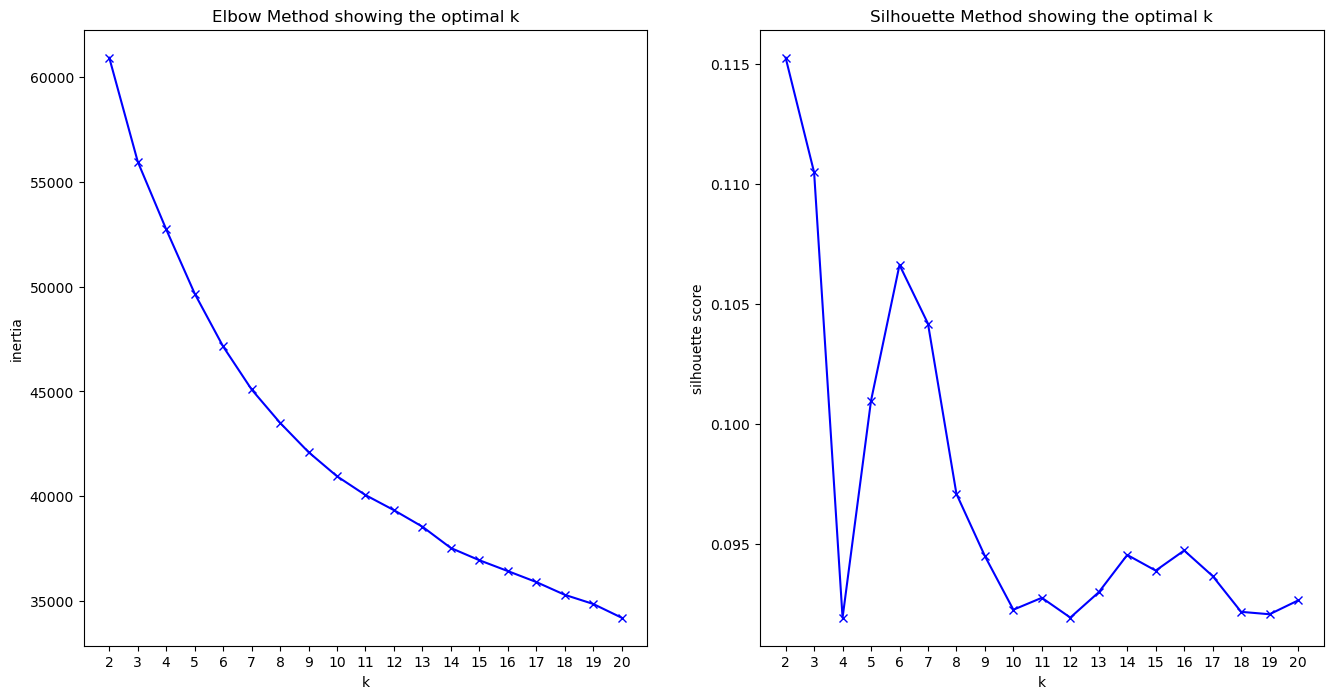

In [25]:
K = range(2, 21)

inertia = []
silhouette = []

for k in K:
    #print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)

    filename = "kmeans_" + str(k) + ".pickle" # Path with filename # kmeans_n.pickle
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

In [26]:
print(silhouette)

[0.11524930971646492, 0.11047232107527813, 0.091909682780679, 0.1009577006140061, 0.10661407939291292, 0.10416812575430927, 0.09707071981371208, 0.09447855731155466, 0.09224341057059929, 0.09274070667356754, 0.09191583438140843, 0.09297222850610064, 0.09452680543397975, 0.09387382539963286, 0.09471156097270282, 0.09364721864853415, 0.09215488086131597, 0.09205439132701444, 0.09262858519479687]


In [27]:
X.to_csv('clustered_songs.csv',index=False)

# the best model is 3

In [28]:
def load(filename = "filename.pickle"):
    try:
        with open(filename, "rb") as file:
            return pickle.load(file)
    except FileNotFoundError:
        print("File not found!")


In [29]:
scaler2 = load("wine_scaler.pickle")
scaler2

StandardScaler()

In [30]:
best_model = load("kmeans_3.pickle")

In [31]:
best_model.predict(X_scaled_df)

array([2, 2, 1, ..., 2, 2, 1])

In [32]:
new_song_features_scaled = scaler2.transform(X_scaled_df)

In [33]:
model =best_model.predict(new_song_features_scaled)

C:\Users\Megha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [40]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from config import *

#Initialize SpotiPy with user credentias #
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret= client_secret))

In [41]:
def recommend_song(df, model):
    # Get the song and artist name from user
    title = input('What is your favourite song?\n')
    artist = input('What is the artist name?\n')
    query = "track:" + title + " artist:" + artist 
    results = sp.search(q=query, limit=1)
    items = results['tracks']['items']

    # Check if the song was found on spotify
    if len(items) == 0:
        print("Unable to find song!")
        sample = "No song"
        url = None
        return sample, url

    # Get the first song
    item = items[0]
    # Get the song id
    song_id = item['id']
    
    # Get song features
    features = sp.audio_features((song_id))[0]
    
    # Create a dataframe of useful features of the song 
    dict_features = { key : [features[key]] for key in list(features.keys()) }
    features_df=pd.DataFrame(dict_features)
    features_df=features_df.drop(columns=["key", "mode", "duration_ms", "time_signature", "analysis_url", "id", "track_href", "type", "uri"], axis=1)

    # Scale features, loading model and getting the user_cluster
    features_scaled_np = scaler.transform(features_df)
    features_scaled_df = pd.DataFrame(features_scaled_np, columns=features_df.columns)
    user_cluster = model.predict(features_scaled_df)[0]

    # Check song id in hot songs
    is_in_hot_df = df[(df['ids'] == song_id) & (df['hot'] == 'Yes')]

    if len(is_in_hot_df) > 0:
        # If it is recommend a song from hot songs in the same cluster
        sample_df = df[(df['hot'] == 'Yes') & (df['clusters'] == user_cluster)].sample(ignore_index=True)
    else:
        # Else recommend a song from the not hot songs in the same cluster
        sample_df = df[(df['hot'] == 'No') & (df['clusters'] == user_cluster)].sample(ignore_index=True)

    url = get_url(sample_df['ids'].values[0])
    title = sample_df['title'].values[0]

    return title, url

In [ ]:
recommend_song(X,model)

What is your favourite song?
megha
What is the artist name?
arijit
